# Model Evaluation / Comparison

In [11]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [12]:
import torch
from tools import plot_column_from_csv, load_model, torcherize_batch, get_data_loader
from tokenizers.bpe.tokenizer import get_tokenizer

In [13]:
models_to_compare = [
    'FHA_GPT_0.8m_2024-05-05|10-54-35',
    'FHA_GPT_0.3m_2024-05-07|13-05-29'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

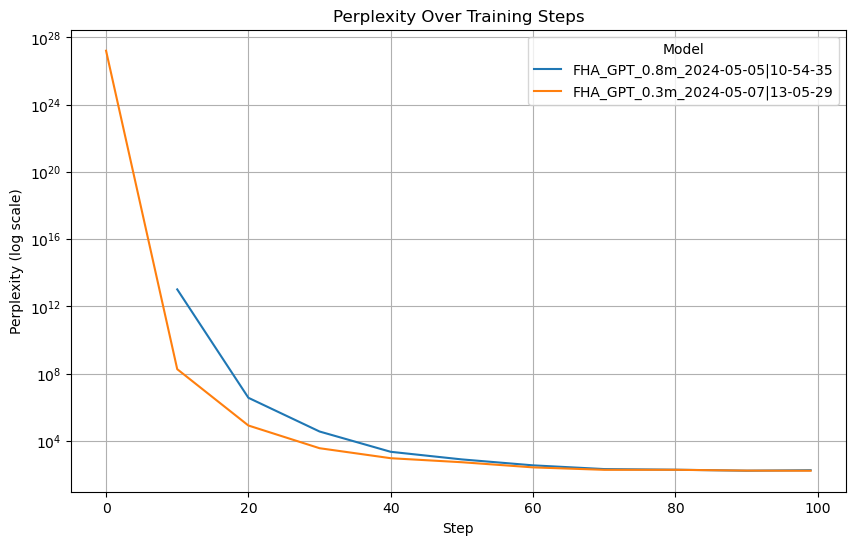

In [14]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies

In [15]:
batch_size = 1 # can only be 1 until i fix batched inference
topk = 5

In [16]:
# Data preparation
data_loader = get_data_loader(batch_size=batch_size, split='validation')
text = next(iter(data_loader))
tokenizer = get_tokenizer(2048)
x, y = torcherize_batch(tokenizer, text, max_seq_len = 256)
# x and y are tensors shape [batch_size, max_seq_len] of dtype torch.int64

print(text[0])
# we want to make sure to choose a y value that takes advantage of the full context for the best estimate,
# so avoid stories that are too short and have padding tokens at teh end
print(y)

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


One day, a bird named Tim wanted to soar high in the sky. He saw an arrow on the ground and thought it was perfect to help him fly. Tim asked his friend, Sam the squirrel, "Can you help me fly with this arrow?"
Sam said, "Yes, let's try!" They tied the arrow to Tim's back and he started to flap his wings. Tim began to soar higher and higher. He was so happy.
But then, something unexpected happened. The arrow turned into a magic wand! Tim and Sam were very surprised. The wand helped Tim fly even higher and faster. They had so much fun and went on many adventures together.
tensor([[ 217, 1916,   89,  108,  184,  951,    2,  583,  339,   96,  227,  197,
         1667,   96,  418,   79,  475,   72,  322, 1209,  192,  144,  153,   75,
           89,   99,  148,  369,  209,  118,  235,  277,  256,  144, 1204,  235,
          661,  644,   96, 1465,    2,  131,    2, 1117, 1037,  105,  465, 1816,
          206,  167,  421,  774, 1221,   99,  227, 1792,  181,  149,  374,  471,
          108,  5

In [17]:
# Function to calculate top-k accuracy
def calculate_topk_accuracy(logits, targets, k=5):
    topk_indices = torch.topk(logits, k, dim=2).indices
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices))
    return correct.any(dim=2).float().mean()

In [18]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    model, _, _ = load_model(model_name)
    model.eval()
    with torch.no_grad():
        logits, _ = model(x)
    
    topk_accuracy = calculate_topk_accuracy(logits, y, k=topk)
    topk_values, topk_indices = torch.topk(logits, topk, dim=2)
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'topk_values': topk_values
    }

ModelConfig(dim=128, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, head_dim=32, theta=10000, max_seq_len=256, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 821.888 K parameters
ModelConfig(dim=64, vocab_len=2051, device='cpu', num_layers=4, second_resid_norm=False, mlp_hidden_mult=2, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, head_dim=32, theta=10000, max_seq_len=256, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1) 

 312.64 K parameters


In [19]:
# Define a function to format the model output
def format_model_output(model_name, data, topk):
    print(f"Model: {model_name}")
    print(f"  - Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    
    # Fetch the top-k predictions for the last token and decode each token
    top_predictions = data['topk_indices'][:,-1,:].squeeze(0).tolist()
    print("  - Top predictions for the last token:")
    for token_index in top_predictions:
        decoded_token = tokenizer.decode([token_index])
        print(f"    - Index: {token_index}, Token: {decoded_token}")
    print()

# Display the results for each model
for name, data in results.items():
    format_model_output(name, data, topk)

# Show the correct value and its decoded form
correct_value = y[:,-1].tolist()
decoded_correct_value = tokenizer.decode(correct_value)
print(f"Correct value: {correct_value[0]} = {decoded_correct_value}")

Model: FHA_GPT_0.8m_2024-05-05|10-54-35
  - Top-5 Accuracy: 23.83%
  - Top predictions for the last token:
    - Index: 2, Token:  
    - Index: 99, Token: . 
    - Index: 144, Token: the
    - Index: 1117, Token: was
    - Index: 206, Token:  t

Model: FHA_GPT_0.3m_2024-05-07|13-05-29
  - Top-5 Accuracy: 23.44%
  - Top predictions for the last token:
    - Index: 2, Token:  
    - Index: 99, Token: . 
    - Index: 108, Token: , 
    - Index: 206, Token:  t
    - Index: 144, Token: the

Correct value: 2050 = 


# once i fix batched inference i need to redo the above code to use that to get a more accurate measurement. also should add some logic to ensure that padding tokens don't get graded and the example is one that doesn't show padding tokens

# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper

# also once the hyperparameter search module is working i should build a system that performs a regression on the hyperparameters tested to predict teacher-forcing topk accuracy. likely need to include both linear, quadratic, & interaction terms in the regression and then do a lasso to remove useless terms